In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '7'

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

import matplotlib.pyplot as plt
import cv2
from PIL import Image

import mediapy as media
import PIL
import io

import matplotlib.patches
import seaborn as sns
from IPython.display import HTML as html_print


%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('../')
sys.path.append('../core')

from raft import RAFT
from train import get_args, load_model
import datasets as raft_datasets
import teachers
import utils.flow_viz as flow_viz
import matplotlib

def segmentation_to_rgb(seg, palette=None, num_objects=None, bg_color=(0, 0, 0)):
    if num_objects is None:
        num_objects = np.max(seg)  # assume consecutive numbering
    num_objects += 1  # background
    if palette is None:
        palette = [bg_color] + sns.color_palette('hls', num_objects-1)

    seg_img = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.float32)
    for i in range(num_objects):
        seg_img[np.nonzero(seg[:, :, 0] == i)] = palette[i]
    return seg_img

def depth_to_rgb(depth, colormap=matplotlib.cm.viridis_r, sqrt=True):
    cmap = np.array(colormap.colors)
    if sqrt:
        d = np.round(np.sqrt((depth[..., 0] / 65535).clip(0, 1.)) * 255).astype(np.uint8)
    else:
        d = np.round(depth[..., 0] // 256).astype(np.uint8)
    return cmap[d]

def flow_to_rgb(vec, flow_mag_range=None, white_bg=False):
    height, width = vec.shape[:2]
    scaling = 50. / (height**2 + width**2)**0.5
    direction = (np.arctan2(vec[..., 0], vec[..., 1]) + np.pi) / (2 * np.pi)
    norm = np.linalg.norm(vec, axis=-1)
    if flow_mag_range is None:
        flow_mag_range = norm.min(), norm.max()
        magnitude = np.clip((norm - flow_mag_range[0]) * scaling, 0., 1.)
    if white_bg == True:
        value = np.ones_like(direction)
        hsv = np.stack([direction, magnitude, saturation], axis=-1)
    else:
        saturation = np.ones_like(direction)
        hsv = np.stack([direction, saturation , magnitude], axis=-1)
        rgb = matplotlib.colors.hsv_to_rgb(hsv)
    return rgb

In [4]:
import sys
sys.path.append('../')
sys.path.append('../core')

from raft import RAFT
from train import get_args, load_model
import datasets as raft_datasets
import teachers
import utils.flow_viz as flow_viz
import matplotlib

def segmentation_to_rgb(seg, palette=None, num_objects=None, bg_color=(0, 0, 0)):
    if num_objects is None:
        num_objects = np.max(seg)  # assume consecutive numbering
    num_objects += 1  # background
    if palette is None:
        palette = [bg_color] + sns.color_palette('hls', num_objects-1)

    seg_img = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.float32)
    for i in range(num_objects):
        seg_img[np.nonzero(seg[:, :, 0] == i)] = palette[i]
    return seg_img

def depth_to_rgb(depth, colormap=matplotlib.cm.viridis_r, sqrt=True):
    cmap = np.array(colormap.colors)
    if sqrt:
        d = np.round(np.sqrt((depth[..., 0] / 65535).clip(0, 1.)) * 255).astype(np.uint8)
    else:
        d = np.round(depth[..., 0] // 256).astype(np.uint8)
    return cmap[d]

def flow_to_rgb(vec, flow_mag_range=None, white_bg=False):
    height, width = vec.shape[:2]
    scaling = 50. / (height**2 + width**2)**0.5
    direction = (np.arctan2(vec[..., 0], vec[..., 1]) + np.pi) / (2 * np.pi)
    norm = np.linalg.norm(vec, axis=-1)
    if flow_mag_range is None:
        flow_mag_range = norm.min(), norm.max()
        magnitude = np.clip((norm - flow_mag_range[0]) * scaling, 0., 1.)
    if white_bg == True:
        value = np.ones_like(direction)
        hsv = np.stack([direction, magnitude, saturation], axis=-1)
    else:
        saturation = np.ones_like(direction)
        hsv = np.stack([direction, saturation , magnitude], axis=-1)
        rgb = matplotlib.colors.hsv_to_rgb(hsv)
    return rgb

In [5]:
import dorsalventral.models.targets as targets
import dorsalventral.vis_utils as vis_utils
import dorsalventral.data as datasets
import dorsalventral.data.utils as data_utils
import dorsalventral.models.fire_propagation as fprop
import dorsalventral.models.layer_utils as layer_utils
import dorsalventral.models.segmentation.competition as competition
import dorsalventral.models.losses as losses
import kornia

In [6]:
# motion_paths = !ls ../checkpoints/[0-9]*motion*dtarg*nthr05*fullplay*pretrained*
# motion_paths = !ls ../checkpoints/[0-9]*motion*tdw*nthr0-cthr025*

# motion_paths = !ls ../checkpoints/[0-9]*motion*movi_d*bs2*nthr0-*gs1*
# motion_paths = !ls ../checkpoints/[0-9]*motion*rnd1*movi_d*bs2*large*gs1*
motion_paths = !ls ../checkpoints/100000*motion*rnd1*movi_d*bs2*small*gs1*

motion_paths = sorted(motion_paths, key=lambda s: int(s.split('/')[-1].split('_')[0]))
# !ls ../checkpoints/*motion*imtarg*thr0*
for i,p in enumerate(motion_paths):
    print(i, p)

0 ../checkpoints/100000_motion-rnd1-movi_d-bs2-small-mt05-bt05-flit24-gs1-pretrained-0.pth


In [7]:
# boundary_paths = !ls ../checkpoints/[0-9]*boundary*rnd1*dtarg*fullplay*pretrained*

# boundary_paths = !ls ../checkpoints/[0-9]*boundaryStaticReg*rnd0*cthr075*fullplay*rerun*
# boundary_paths = !ls ../checkpoints/[0-9]*boundaryMotionReg*rnd0*small*nthr0*cthr075*fullplay*
# boundary_paths = !ls ../checkpoints/[0-9]*boundaryMotionReg*rnd1*tdw*small*

# boundary_paths = !ls ../checkpoints/[0-9]*boundaryStatic*rnd0*movi_d*nthr0-*gs1*
# boundary_paths = !ls ../checkpoints/100000*boundaryMotion*rnd0*movi_d*nthr0-*gs1*

boundary_paths = !ls ../checkpoints/100000*boundaryMotion*rnd1*movi_d*small*gs1*-1*
# boundary_paths = !ls ../checkpoints/100000*boundaryMotion*rnd0*movi_d*gs1*


boundary_paths = sorted(boundary_paths, key=lambda s: int(s.split('/')[-1].split('_')[0]))
for i,p in enumerate(boundary_paths):
    print(i, p)

0 ../checkpoints/100000_boundaryMotionReg-rnd1-movi_d-bs2-small-mt05-bt05-flit24-gs1-pretrained-1.pth


In [8]:
# flow_paths = !ls ../checkpoints/[0-9]*flowBoundary*bmt*movi_d*gs1*
# flow_paths = !ls ../checkpoints/[0-9]*flowBoundary*rnd0*movi_d*gs1*
# flow_paths = !ls ../checkpoints/[0-9]*flowBoundary*rnd1*movi_d*large*gs1*
flow_paths = !ls ../checkpoints/100000*flowBoundary*rnd1*movi_d*small*gs1*
# flow_paths = !ls ../checkpoints/[0-9]*flowCentroids*rnd2*movi_d*small*gs1*

# flow_paths = !ls ../checkpoints/[0-9]*flowBoundary*tdw*
# flow_paths = !ls ../checkpoints/100000*flowBoundary*rnd0*movi_d*gs1*


flow_paths = sorted(flow_paths, key=lambda s: int(s.split('/')[-1].split('_')[0]))
# !ls ../checkpoints/*motion*imtarg*thr0*
for i,p in enumerate(flow_paths):
    print(i, p)

0 ../checkpoints/100000_flowBoundary-rnd1-movi_d-bs2-small-mt05-bt05-flit24-gs1-pretrained-1.pth


In [9]:
# e_path = '../checkpoints/80000_eisen_teacher_v1_128_bs4.pth'
e_path = '../checkpoints/30000_eisen_teacher_v1_64_bs16.pth'

print(e_path)

../checkpoints/30000_eisen_teacher_v1_64_bs16.pth


In [183]:
m_idx = -1
b_idx = -1
f_idx = -1
m_path = motion_paths[m_idx]
b_path = boundary_paths[b_idx]
f_path = flow_paths[f_idx]
boot_paths = {
    'motion_path': m_path,
    'boundary_path': b_path,
    'flow_path': f_path
}

stride = 2
T_group = 2
T_track = 1
T = 2
use_gt = False
use_eisen = False
if use_eisen:
    static_path = e_path
elif use_gt:
    static_path = 'ground_truth'
else:
    static_path = None

BBNet = teachers.BipartiteBootNet(
#     student_model_type='flow_centroids',
#     target_model_params={},
    static_path=static_path,
#     static_params={'radius': 7},
    static_params={'stem_pool': (stride == 4), 'affinity_res': [256//stride,256//stride]},
    input_keys={'static': 'objects'} if use_gt else {},
    boot_paths=boot_paths,
    downsample_factor=stride,
    grouping_window=T_group,
    tracking_step_size=T_track,
    static_resolution=4,
    dynamic_resolution=3
).cuda().eval()


# data_dir = '/mnt/fs6/honglinc/dataset/tensorflow_datasets/movi_c/256x256/1.0.0'
data_dir = '/data2/honglinc/movi_d/256x256/1.0.0'
movi_dataset = datasets.movi.MoviDataset(
    dataset_dir=data_dir,
    split='validation',
    sequence_length=T,
    min_start_frame=12-(T//2),
    max_start_frame=12-(T//2),
    is_test=False
)
print(len(movi_dataset))

Plateau map dimensions: [stat 16, dyn 9, rand 0, total 144]
<All keys matched successfully> MotionClassifier ../checkpoints/100000_motion-rnd1-movi_d-bs2-small-mt05-bt05-flit24-gs1-pretrained-0.pth
<All keys matched successfully> BoundaryClassifier ../checkpoints/100000_boundaryMotionReg-rnd1-movi_d-bs2-small-mt05-bt05-flit24-gs1-pretrained-1.pth
<All keys matched successfully> RAFT ../checkpoints/100000_flowBoundary-rnd1-movi_d-bs2-small-mt05-bt05-flit24-gs1-pretrained-1.pth
250


In [184]:
ex = 0
# data = movi_eval_dataset[ex]
for e in range(ex+1):
    data = movi_dataset[e]
video = data['images']
print("video", video.shape)
# preds, plateau, segments, full_segments = BBNet(video[None].cuda())
stitch_segments = []
# windows = [[0,4],[2,6]]
# for w in windows:
bbnet_preds = BBNet(
#     video[None].cuda(),
    {k:data[k][None][:].cuda() for k in ['images', 'objects']},
    boot_params={'bootstrap': True, 'flow_iters': 24},
    static_params={'to_image': True, 'local_window_size': None},
    mask_with_motion=True,
    use_temporal_affinities=True,
    run_cc=False
)
if BBNet.student_model_type is None:
    preds, plateau, segments, full_segments = bbnet_preds
    mask = preds[-1][:,:,0,...,None]
elif BBNet.student_model_type in ['flow', 'flow_centroids']:
    s2m_target = bbnet_preds
elif BBNet.student_model_type in ['centroids']:
    dcentroid_target, thingness = bbnet_preds

    
full_segments_stitched = full_segments

movie, frame b'3835' 11
video torch.Size([2, 3, 256, 256])


In [180]:
# full_segments_stitched = BBNet.stitch_segment_movies(stitch_segments[0], stitch_segments[1], overlap_window=2)

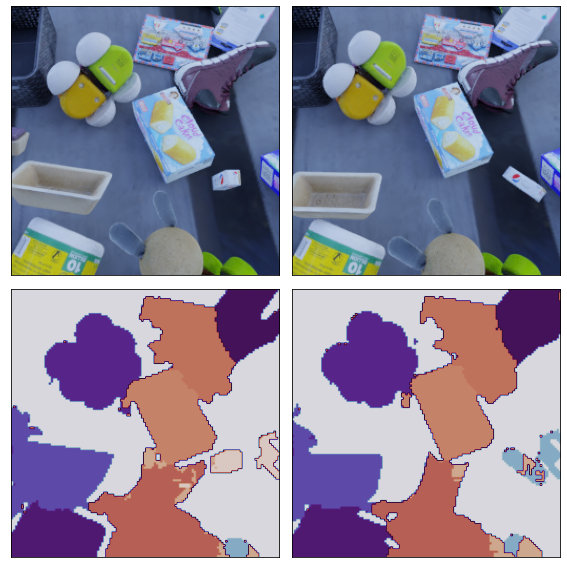

In [185]:
T_full = full_segments_stitched.shape[1]
fig, axes = plt.subplots(2,T_full, figsize=(4*T_full, 8))
for t in range(T_full):
    vis_utils.imshow(data['images'][None,t], axes[0][t])
    vis_utils.imshow(full_segments_stitched[:,t,None], axes[1][t], cmap='twilight', vmin=-1, vmax=33)
    for ax in axes[:,t]:
        ax.set_xticks([])
        ax.set_yticks([])
plt.tight_layout()
plt.show()

In [182]:
import dorsalventral.evaluation.object_metrics as om
T_eval = T
segments_rz = transforms.Resize([256,256], interpolation=transforms.InterpolationMode.NEAREST)(
    full_segments_stitched)
print(T_eval, segments_rz.shape)
ari = om.adjusted_rand_index(
    pred_ids=(full_segments_stitched[:,:T_eval]+1).long(),
    true_ids=data['objects'][None,:T_eval,0,::BBNet.stride,::BBNet.stride].long().cuda(),
    num_instances_pred=(full_segments_stitched[:,:T_eval]+1).amax().item()+1,
    num_instances_true=data['objects'][:T_eval].amax().item()+1,
    ignore_background=True
)
print(ari)

ari = om.adjusted_rand_index(
    pred_ids=(segments_rz[:,:T_eval]+1).long(),
    true_ids=data['objects'][None,:T_eval,0].long().cuda(),
    num_instances_pred=(segments_rz[:,:T_eval]+1).amax().item()+1,
    num_instances_true=data['objects'][:T_eval].amax().item()+1,
    ignore_background=True
)
print(ari)

2 torch.Size([1, 2, 256, 256])
tensor([0.4741], device='cuda:0')
tensor([0.4729], device='cuda:0')


In [44]:
ccs = kornia.contrib.connected_components(
    full_segments.view(-1,1,128,128).float(), 
    num_iterations=500
).view(1,-1,128,128).long()

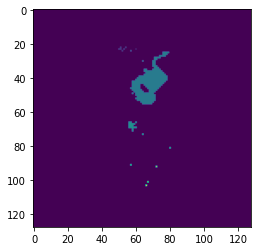

In [46]:
_, y = torch.unique(ccs[:,0:1], return_inverse=True)
vis_utils.imshow(y)

In [162]:
## compute the largest CC in each image or suppress all that fall below a size thresh.
## Set all the rest to some background value, like -1 or 32.
## then mask the full segments
filtered = teachers.BipartiteBootNet.filter_segments_by_connected_components(
    full_segments, top_k=32, min_area=100)

    

tensor([131072,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      2,      1,      2,      1,      1,   1585,      2,
             1,      1,      1,      6,      1,      1,    300,     17,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      3,      3,   1452,      1,     16,     30,     25,     27,
         11527,     45,      2,      1,      1,      6,      1,      1,      1,
             1,      1,    373,      1,     48,      1,      1,      1,      2,
             1,      4,      2,      2,      3,      1,      4,      1,      1,
             2,      1,      2,    334,      2,     19,      1,      1,      1,
             1,      1,      1,      1,    232,      1,      8,      1,      3,
           231,      1,      1,      1,      4,      1], device='cuda:0')
torch.Size([96]) tensor(9, device='cuda:0')
tensor([131072,      4,      1,      1,      1,      1,      1,      1,      1,
  

In [164]:
filtered.shape

torch.Size([1, 2, 128, 128])

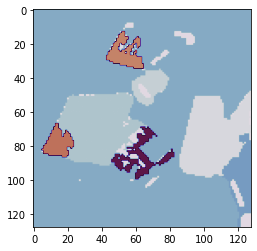

In [168]:
vis_utils.imshow(filtered[:,1:2], cmap='twilight', vmin=-1, vmax=33)

In [169]:
import dorsalventral.evaluation.object_metrics as om
T_eval = T
segments_rz = transforms.Resize([256,256], interpolation=transforms.InterpolationMode.NEAREST)(
    filtered)
print(T_eval, segments_rz.shape)
# ari = om.adjusted_rand_index(
#     pred_ids=(full_segments_stitched[:,:T_eval]+1).long(),
#     true_ids=data['objects'][None,:T_eval,0,::BBNet.stride,::BBNet.stride].long().cuda(),
#     num_instances_pred=(full_segments_stitched[:,:T_eval]+1).amax().item()+1,
#     num_instances_true=data['objects'][:T_eval].amax().item()+1,
#     ignore_background=True
# )
# print(ari)

ari = om.adjusted_rand_index(
    pred_ids=(segments_rz[:,:T_eval]+1).long(),
    true_ids=data['objects'][None,:T_eval,0].long().cuda(),
    num_instances_pred=(segments_rz[:,:T_eval]+1).amax().item()+1,
    num_instances_true=data['objects'][:T_eval].amax().item()+1,
    ignore_background=True
)
print(ari)

2 torch.Size([1, 2, 256, 256])
tensor([0.5287], device='cuda:0')


In [178]:
### ex 0 MoviD

### middle 6 frames
# Tgroup = 2: 0.42
# Tgroup = 3: 0.53
# Tgroup = 4: 0.61
# Tgroup = 5: 0.63
# Tgroup = 6: 0.65

# Tgroup = 4, Ttrack = 2: 0.71

### middle 8 frames
# Tgroup = 6: 0.52
# Tgroup = 8: 0.56

# Tgroup = 6, Ttrack = 2: 0.49

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [179]:
stitched = BBNet.stitch_segment_movies(full_segments[:,0:2], full_segments[:,2:4] + 5)

torch.Size([1, 1, 64, 64, 29]) torch.Size([1, 1, 64, 64, 34]) torch.Size([1, 29, 34])


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


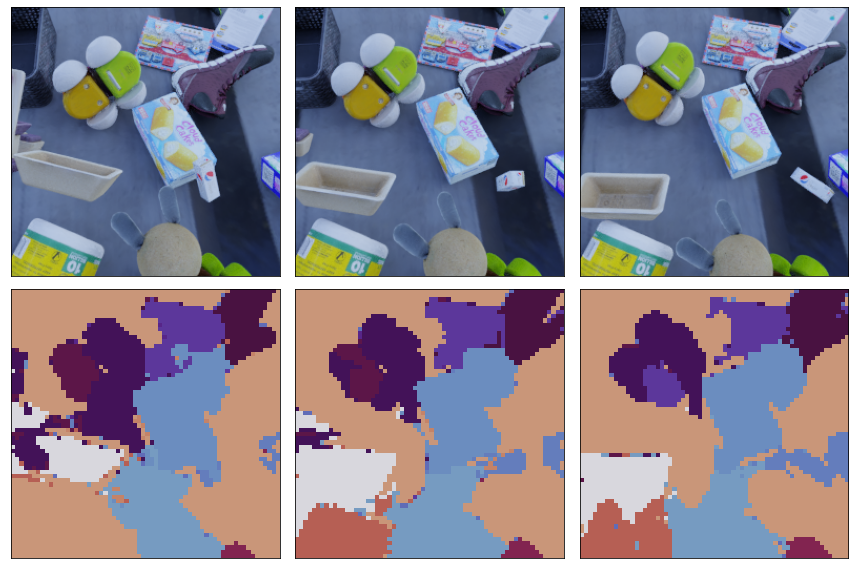

In [182]:
T_full = stitched.shape[1]
fig, axes = plt.subplots(2,T_full, figsize=(4*T_full, 8))
for t in range(T_full):
    vis_utils.imshow(data['images'][None,t], axes[0][t])
    vis_utils.imshow(stitched[:,t,None], axes[1][t], cmap='twilight', vmin=-1, vmax=33)
    for ax in axes[:,t]:
        ax.set_xticks([])
        ax.set_yticks([])
plt.tight_layout()
plt.show()

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


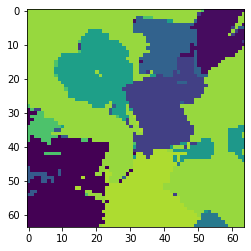

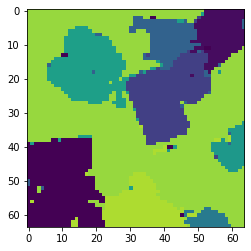

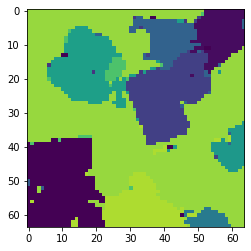

In [165]:
vis_utils.imshow(full_segments[:,1:2], vmin=0, vmax=32)
vis_utils.imshow(segs2_stitch[:,0:1], vmin=0, vmax=32)
vis_utils.imshow(full_segments[:,2:3], vmin=0, vmax=32)


In [118]:
parents_of_segs2 = scores.argmax(-1)
parents_of_segs2

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


tensor([[ 0,  1,  0,  0,  0, 18,  6,  0,  0,  0, 10,  0,  0, 13,  0,  0,  0, 17,
         18,  0,  0,  0,  0, 27,  0,  0,  0, 27, 28]], device='cuda:0')

In [122]:
scores[0,parents_of_segs2,torch.arange(parents_of_segs2.shape[-1], dtype=torch.long, device=scores.device)]

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


tensor([[0.7549, 0.7672, 0.0000, 0.0000, 0.0000, 0.0026, 0.6848, 0.0000, 0.0000,
         0.0036, 0.6550, 0.0000, 0.0000, 0.5263, 0.0000, 0.0000, 0.0000, 0.2568,
         0.6093, 0.0000, 0.0000, 0.0000, 0.0000, 0.0048, 0.0000, 0.0000, 0.0000,
         0.6729, 0.5734]], device='cuda:0')

In [124]:
fs = full_segments[0,0]
torch.unique(fs)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


tensor([ 0,  1,  5,  6,  9, 10, 13, 17, 18, 23, 27, 28], device='cuda:0')

In [125]:
fs[fs == 1] = 30
torch.unique(fs)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


tensor([ 0,  5,  6,  9, 10, 13, 17, 18, 23, 27, 28, 30], device='cuda:0')

In [ ]:
# each mask in segs2 needs to have a parent in segs1
# if a mask in segs2 has two parents in segs1, go with the higher miou
# if two masks in segs2 have the same parent in segs1, either one has to die or they have to merge

In [127]:
for i in list(torch.unique(fs)):
    fs[fs == i] = 42 + i
torch.unique(fs)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


tensor([42, 47, 48, 51, 52, 55, 59, 60, 65, 69, 70, 72], device='cuda:0')

# Quantification

In [72]:
METRIC_NAMES = ['fari', 'ari', 'miou', 'recall50']
def aggregate_results(results):

    examples = sorted(results.keys())
    if len(examples) == 0:
        return None

    metric_names = results[examples[0]].keys()
    agg = {nm:[] for nm in metric_names}

    for ex in examples:
        for nm in metric_names:
            agg[nm].append(results[ex][nm])

    for nm in metric_names:
        if nm in METRIC_NAMES:
            agg[nm+'_std'] = np.nanstd(np.array(agg[nm]))
            agg[nm] = np.nanmean(np.array(agg[nm]))

    return agg

In [73]:
import test
import pickle,os,sys

In [74]:
results = !ls ../results/bbnet
for i,res in enumerate(results):
    print(i, res)

0 bootnet-Bootstrap-MoMask-128x128-movi_c-250ex.pkl
1 bootnet-Bootstrap-MoMask-128x128-movi_d-250ex.pkl
2 bootnet-Bootstrap-MoMask-128x128-movi_e-250ex.pkl
3 bootnet-Bootstrap-MoMask-movi_c-250ex.pkl
4 bootnet-Bootstrap-MoMask-movi_d-250ex.json
5 bootnet-Bootstrap-MoMask-movi_e-250ex.pkl
6 bootnet-Bootstrap-movi_d-250ex.json
7 bootnet-noBootstrap-Mask-movi_d-10ex.json
8 bootnet-noBootstrap-MoMask-movi_d-250ex.json
9 bootnet-noBootstrap-movi_d-250ex.json
10 bootup-only-movi_d-10ex.json
11 bootup-only-movi_d-1ex.json
12 round1Eisen-Bootstrap-128x128_movi_d-10ex.pkl
13 round1Eisen-Bootstrap-64x64_movi_d-10ex.pkl
14 round1Eisen-Bootstrap-MoMask-128x128_movi_d-10ex.pkl
15 round1Eisen-Bootstrap-movi_c-250ex.pkl
16 round1Eisen-Bootstrap-movi_d-250ex.pkl
17 round1Eisen-Bootstrap-movi_e-250ex.pkl
18 round1Eisen-noBootstrap-128x128_movi_d-10ex.pkl
19 testeisen.pkl


In [90]:
r_idx = 3
result_path = results[r_idx]
with open(os.path.join('../results/bbnet', result_path), 'rb') as f:
    res = aggregate_results(pickle.load(f))
print(result_path)
print("num examples -- %d" % len(res['example']))
for nm in METRIC_NAMES:
    print(nm, res.get(nm, None))

bootnet-Bootstrap-MoMask-movi_c-250ex.pkl
num examples -- 250
fari 0.46247582946019244
ari 0.6641393283307553
miou None
recall50 None


In [91]:
r_idx = 15
result_path = results[r_idx]
with open(os.path.join('../results/bbnet', result_path), 'rb') as f:
    res = aggregate_results(pickle.load(f))
print(result_path)
print("num examples -- %d" % len(res['example']))
for nm in METRIC_NAMES:
    print(nm, res.get(nm, None))

round1Eisen-Bootstrap-movi_c-250ex.pkl
num examples -- 250
fari 0.4735544607192278
ari 0.049608846735209225
miou None
recall50 None


### implement miou and recall

In [135]:
import dorsalventral.evaluation.object_metrics as metrics

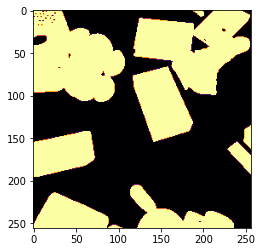

In [185]:
vis_utils.imshow(data['flow'].square().sum(1, True).sqrt() > 0.1, t=-1, cmap='inferno', vmin=0, vmax=1)

In [98]:
data['flow'].amax()

tensor(51892.)

In [113]:
competition.compute_pairwise_overlaps?

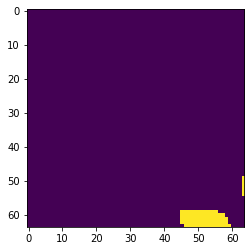

In [130]:
vis_utils.imshow(full_segments[:,-1:] == 8)

In [141]:
pred_masks = metrics.segments_to_masks(full_segments)
true_masks = metrics.segments_to_masks(data['objects'][None,:,0,...,::4,::4])

In [142]:
full_masks.shape, true_masks.shape

(torch.Size([1, 6, 64, 64, 17]), torch.Size([1, 6, 64, 64, 13]))

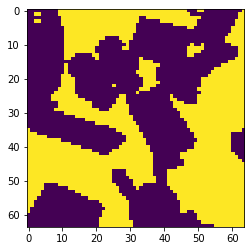

In [143]:
vis_utils.imshow(true_masks[:,0:1,...,0])

In [156]:
overlaps = competition.compute_pairwise_overlaps(true_masks.view(1,6*64*64,-1).cuda(),
                                                 pred_masks.view(1,6*64*64,-1).cuda())

In [157]:
overlaps.amax(-1)

tensor([[0.6377, 0.5659, 0.3552, 0.6336, 0.8237, 0.1047, 0.8479, 0.6207, 0.3920,
         0.6921, 0.0830, 0.5271, 0.0081]], device='cuda:0')

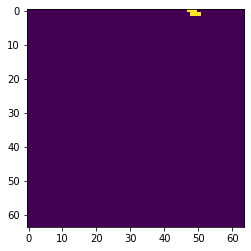

In [150]:
vis_utils.imshow(true_masks[:,0:1,...,-1])

In [201]:
miou, ious, matches, msizes = metrics.miou(full_segments[:,-1:], 
                                           data['objects'][None,-1:,0,...,::4,::4].cuda(),
                                           min_size=0,
                                           ignore_background=True
                                          )
recall50 = metrics.recall(ious, 0.5)
recall75 = metrics.recall(ious, 0.75)
recall90 = metrics.recall(ious, 0.9)

print(miou, recall50, recall75, recall90)

tensor(0.4895, device='cuda:0') tensor(0.4167, device='cuda:0') tensor(0.3333, device='cuda:0') tensor(0., device='cuda:0')


In [207]:
ious[msizes[] > 50]

IndexError: too many indices for tensor of dimension 1

In [215]:
torch.where(msizes[0] > 25)[0]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], device='cuda:0')